# Social Reward Task Error Audit

**Import packages**

In [1]:
import os
import pandas as pd
import glob
import numpy as np
import seaborn as sns

**Set directories**

In [2]:
task_dir = '/Volumes/research$/redcay/DSCN Lab/Experiments/SCONN/task_socialreward/'
data_dir = task_dir+'data/'
rdcp_dir = task_dir+'stimuli/Redcap/wide_answers/'

os.chdir(data_dir)


**Create a list of participants**

In [3]:
subj_list = [x for x in os.walk(data_dir)][0][1]
subj_list.remove('SCN_00T')
subj = subj_list[0]

print('Found '+str(len(subj_list))+' participants')

Found 131 participants


## Set up master item list

In [4]:
master_items = pd.read_csv(task_dir+'stimuli/SocialConnection_Master.csv')
n_items = len(master_items)
master_items

,ItemNumber,Item_neg,Item_pos,Block,ITI0,ISI0,ITI,ISI
0,1,not an animal lover,an animal lover,1.0,2.225983,2.076967,1.15600,4.0015
1,2,not superstitious,superstitious,1.0,3.985426,3.398669,0.96831,2.6719
2,3,don't like jazz,like jazz,1.0,5.675676,2.599246,2.06340,2.3704
3,4,don't like short stories,like short stories,1.0,2.182871,2.013044,4.62070,3.5144
4,5,not a feminist,a feminist,1.0,3.718975,5.283200,3.89710,2.0334
...,...,...,...,...,...,...,...,...
206,207,don't speak French,speak French,NaN,NaN,NaN,NaN,NaN
207,208,don't like libraries,like libraries,NaN,NaN,NaN,NaN,NaN
208,209,don't play video games,play video games,NaN,NaN,NaN,NaN,NaN
209,210,don't like guitars,like guitars,NaN,NaN,NaN,NaN,NaN


### Create dataframe of item valences
This will be used to get the valence of the answers presented during the task

In [5]:
item_valence = pd.DataFrame(np.array([list(master_items['Item_pos']) + list(master_items['Item_neg']),
                             ['pos']*n_items + ['neg']*n_items]).T,
                           columns=['item', 'valence'])
item_valence['item'] = item_valence['item'].str.strip()
item_valence['item'] = item_valence['item'].str.lower()
item_valence

,item,valence
0,an animal lover,pos
1,superstitious,pos
2,like jazz,pos
3,like short stories,pos
4,a feminist,pos
...,...,...
417,don't speak french,neg
418,don't like libraries,neg
419,don't play video games,neg
420,don't like guitars,neg


In [6]:
# Replace item strings to match what is shown during the task
item_valence['item'].replace({"don’t like young adult lit": "dont like young adult lit",
                              "don√ït like phone calls": "don't like phone calls",
                              "don’t like watching tv": "dont like watching tv"},
                                                    inplace=True)


In [7]:
[x for x in item_valence['item'] if 'tv' in x]

['like watching tv',
 'like reality tv',
 'dont like watching tv',
 "don't like reality tv"]

## Find errors for all participants
This will calculate the number of errors for each participant, and export updated run data files, indicating which items were incorrectly valenced.

In [8]:
# Create dataframe which will track the number of errors for each participant
subj_error_df = pd.DataFrame(columns=['num_errors'], index=subj_list)

In [9]:

redcap_data = pd.read_csv(rdcp_dir+subj+'.csv')
# Remove irrelavant columns
redcap_data = redcap_data.drop(columns=['record_id', 'redcap_event_name', 'social_reward_fmri_complete'],
                                      errors='ignore')
redcap_data = redcap_data.drop(columns=[col for col in redcap_data if col.startswith('open')],
                                      errors='ignore')
        
# Transpose so each row is an item
redcap_data = redcap_data.T

# Convert item labels into a column
redcap_data.reset_index(inplace=True)
redcap_data

,index,0
0,socrew1,4
1,socrew2,2
2,socrew3,1
3,socrew4,4
4,socrew5,5
...,...,...
206,socrew207,1
207,socrew208,2
208,socrew209,2
209,socrew210,2


In [10]:
for subj in subj_list:
    run_files = glob.glob(data_dir+subj+'/*.csv')
    run_files = [x for x in run_files if 'errors' not in x]
    if not len(run_files) > 0:
        continue

    subj_error_df.loc[subj, 'num_errors'] = 0
    
    for run_file in run_files:
        run_data = pd.read_csv(run_file, index_col=0, encoding_errors='ignore')

        # Make questions lower case
        run_data['Question'] = run_data['Question'].str.lower()

        # Replace certain strings which are being read wrong
        run_data['Question'].replace({"don’t like young adult lit": "dont like young adult lit",
                                       "don√ït like phone calls": "don't like phone calls",
                                       "don’t like watching tv": "dont like watching tv"},
                                                    inplace=True)

        # Match item valence to task item
        run_data_check = pd.merge(left=run_data, right=item_valence,
                         left_on="Question", right_on="item",
                         how="left")

        # Import participant survey data
        redcap_data = pd.read_csv(rdcp_dir+subj+'.csv')
        
        # Remove irrelavant columns
        redcap_data = redcap_data.drop(columns=['record_id', 'redcap_event_name', 'social_reward_fmri_complete'],
                                      errors='ignore')
        redcap_data = redcap_data.drop(columns=[col for col in redcap_data if col.startswith('open')],
                                      errors='ignore')
        
        # Transpose so each row is an item
        redcap_data = redcap_data.T
        
        # Convert item labels into a column
        redcap_data.reset_index(inplace=True)
        
        # Rename columns
        redcap_data.columns = ['item', 'rating']
        
        # Remove prefix from item labels
        redcap_data['item'] = [int(x.removeprefix('socrew')) for x in redcap_data['item']]

        # Add participant ratings to run data items
        run_data_check = pd.merge(left=run_data_check, right=redcap_data,
                                 left_on="QuestionNumber", right_on="item",
                                 how="left")

        # Replace number ratings with valence category labels
        run_data_check['valence_redcap'] = run_data_check['rating'].to_list()
        run_data_check['valence_redcap'] = run_data_check['valence_redcap'].replace([1, 2], 'neg')
        run_data_check['valence_redcap'] = run_data_check['valence_redcap'].replace([4, 5], 'pos')

        # Check if redcap valence matches task valence
        run_data_check['redcap_v_task'] = np.where(run_data_check['valence_redcap'] == run_data_check['valence'], 0, 1)
        subj_error_df.loc[subj, 'num_errors'] += run_data_check['redcap_v_task'].sum()

        # Export updated task output with noted errors
        run_data_check.to_csv(run_file[:-4]+'-errors.csv')

In [11]:
subj_error_df.tail(10)

,num_errors
SCN_272,0
SCN_275,0
SCN_277,0
SCN_278,0
SCN_279,0
SCN_283,0
SCN_285,0
SCN_286,0
SCN_287,0
SCN_289,0


## Visualization

Text(0.5, 1.0, 'Distribution of Number of Errors')

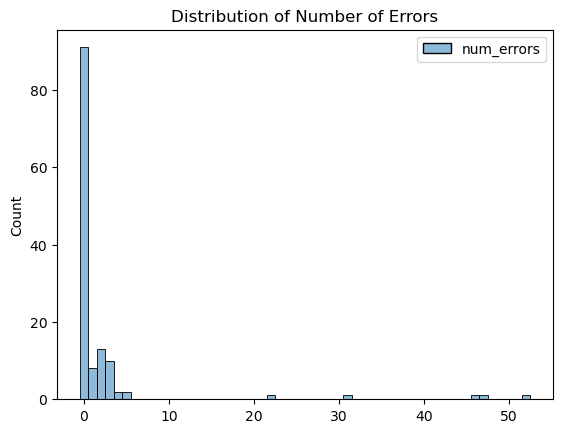

In [12]:
fig = sns.histplot(subj_error_df, discrete=True)
fig.set_title('Distribution of Number of Errors')

**Export error counts**

In [13]:
subj_error_df = subj_error_df.sort_index()

In [14]:
subj_error_df.to_csv(data_dir+'answer_errors_sum.csv')

In [15]:
# Number of participants with errors
len(subj_error_df[subj_error_df['num_errors'] > 0])

40

In [16]:
# Number of participants with a lot of errors
len(subj_error_df[subj_error_df['num_errors'] > 5])

5

In [17]:
# Number of participants with no errors
len(subj_error_df[subj_error_df['num_errors'] == 0])

91

## Check errors for specific participant
Useful for examining specific errors and troubleshooting.

In [18]:
subj = 'SCN_289'

run_files = glob.glob(data_dir+subj+'/*.csv')
run_files = [x for x in run_files if 'errors' in x]


subj_spec_errors = pd.DataFrame()
    
for run_file in run_files:
    run_data = pd.read_csv(run_file, index_col=0, encoding_errors='ignore')

    temp_errors = run_data[run_data['redcap_v_task'] > 0]

    subj_spec_errors = pd.concat([subj_spec_errors, temp_errors])

subj_spec_errors

,ParticipantID,Run,Condition,ConditionName,Question,QuestionNumber,peerName,left_or_right,FirstButtonPressTime,CorrectButtonPressTime,...,TrialEnd_Length,FixStart,FixDur,FixEnd,item_x,valence,item_y,rating,valence_redcap,redcap_v_task


In [19]:
subj_spec_errors[['Question', 'item_x']]

,Question,item_x


In [20]:
[x for x in item_valence['item'] if 'adult' in x]

['like young adult lit', 'dont like young adult lit']